<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep10-eda-modeling?scriptVersionId=121280317" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Description](#4)

[5. Data Exploration](#5)

[6. Baseline Modeling 1.0](#6)
 - [6.1 Random Forest](#6.1)
 - [6.2 HistGradientBoosting](#6.2)
    
<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (03/06/2023)
    * EDA 
    * Baseline modeling 1.0    
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e10/train.csv')
test = pd.read_csv('../input/playground-series-s3e10/test.csv')
submission = pd.read_csv('../input/playground-series-s3e10/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (117564, 10)
The dimession of the test dataset is: (78377, 9)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    117564 non-null  int64  
 1   Mean_Integrated       117564 non-null  float64
 2   SD                    117564 non-null  float64
 3   EK                    117564 non-null  float64
 4   Skewness              117564 non-null  float64
 5   Mean_DMSNR_Curve      117564 non-null  float64
 6   SD_DMSNR_Curve        117564 non-null  float64
 7   EK_DMSNR_Curve        117564 non-null  float64
 8   Skewness_DMSNR_Curve  117564 non-null  float64
 9   Class                 117564 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 9.0 MB


In [4]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [5]:
train.describe()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,58781.500000,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076,0.093285
std,33937.947861,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110,0.290833
min,0.000000,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976,0.000000
25%,29390.750000,104.546875,43.443390,0.049761,-0.188956,2.090301,14.955405,6.742911,49.409136,0.000000
50%,58781.500000,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375,0.000000
75%,88172.250000,126.296875,50.862718,0.395620,0.691613,4.122910,24.732218,10.003237,122.093290,0.000000
max,117563.000000,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837,1.000000


In [6]:
test.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,117564,140.046875,54.507800,0.058862,-0.567263,2.337793,14.868335,9.591760,117.988781
1,117565,107.828125,51.578965,0.284368,-0.338430,1.574415,12.501437,11.694968,182.704822
2,117566,135.062500,49.812343,-0.087784,-0.094341,3.576923,21.243336,7.252386,59.021499
3,117567,112.812500,41.926647,0.519921,1.287762,6.669732,29.013153,5.097661,27.105240
4,117568,96.210938,35.322620,0.481286,2.443080,2.218227,17.041064,9.766006,117.131775


In [7]:
test.describe()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
count,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000
mean,156752.000000,111.328650,46.729918,0.494829,1.833997,11.857477,26.075380,8.048395,94.034477
std,22625.635361,24.682112,6.088317,1.111206,6.401282,26.610344,19.929691,3.826233,79.905613
min,117564.000000,5.812500,24.772042,-1.788449,-1.791886,0.213211,7.448817,-2.556795,-1.976976
25%,137158.000000,104.585938,43.502110,0.050069,-0.190423,2.088629,14.954451,6.755894,49.704203
50%,156752.000000,116.554688,47.465944,0.185460,0.090628,2.803512,18.164951,8.444376,83.322761
75%,176346.000000,126.195312,50.854073,0.394856,0.692126,4.099498,24.547813,9.973464,122.093290
max,195940.000000,192.617188,91.808628,8.069522,64.117478,223.392141,110.544845,31.471559,1072.793069


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Pulsar Classification for Class Prediction](https://www.kaggle.com/datasets/brsdincer/pulsar-classification-for-class-prediction) dataset. These are the descriptions of the variables in this dataset:

<ul>
    <li> Mean_Integrated: mean of observations. </li>
    <li> SD: standard deviation of observations. </li>
    <li> EK: excess kurtosis of observations. </li>
    <li> Skewness: skewness of the observations. </li>
    <li> Mean_DMSNR_Curve: mean of DM SNR CURVE of observations. </li>
    <li> SD_DMSNR_Curve: standard deviation of DM SNR CURVE of observations. </li>
    <li> EK_DMSNR_Curve: excess kurtosis of DM SNR CURVE of observations . </li>
    <li> Skewness_DMSNR_Curve: skewness of DM SNR CURVE of observations. </li>
    <li> Class: Class 0 - 1.</li>
</ul>


<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

In [8]:
round(100*train['Class'].value_counts() / train.shape[0], 2) 

0    90.67
1     9.33
Name: Class, dtype: float64

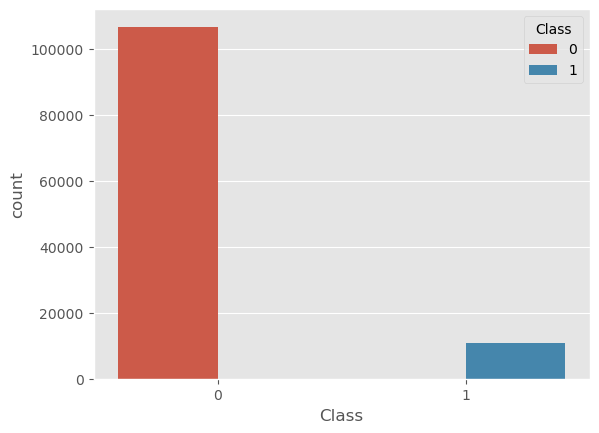

In [9]:
sns.countplot(x = 'Class', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that the data is imbalanced (approx. to be 90-10).</div>

We next proceed to explore the relationship between the input and target variables.

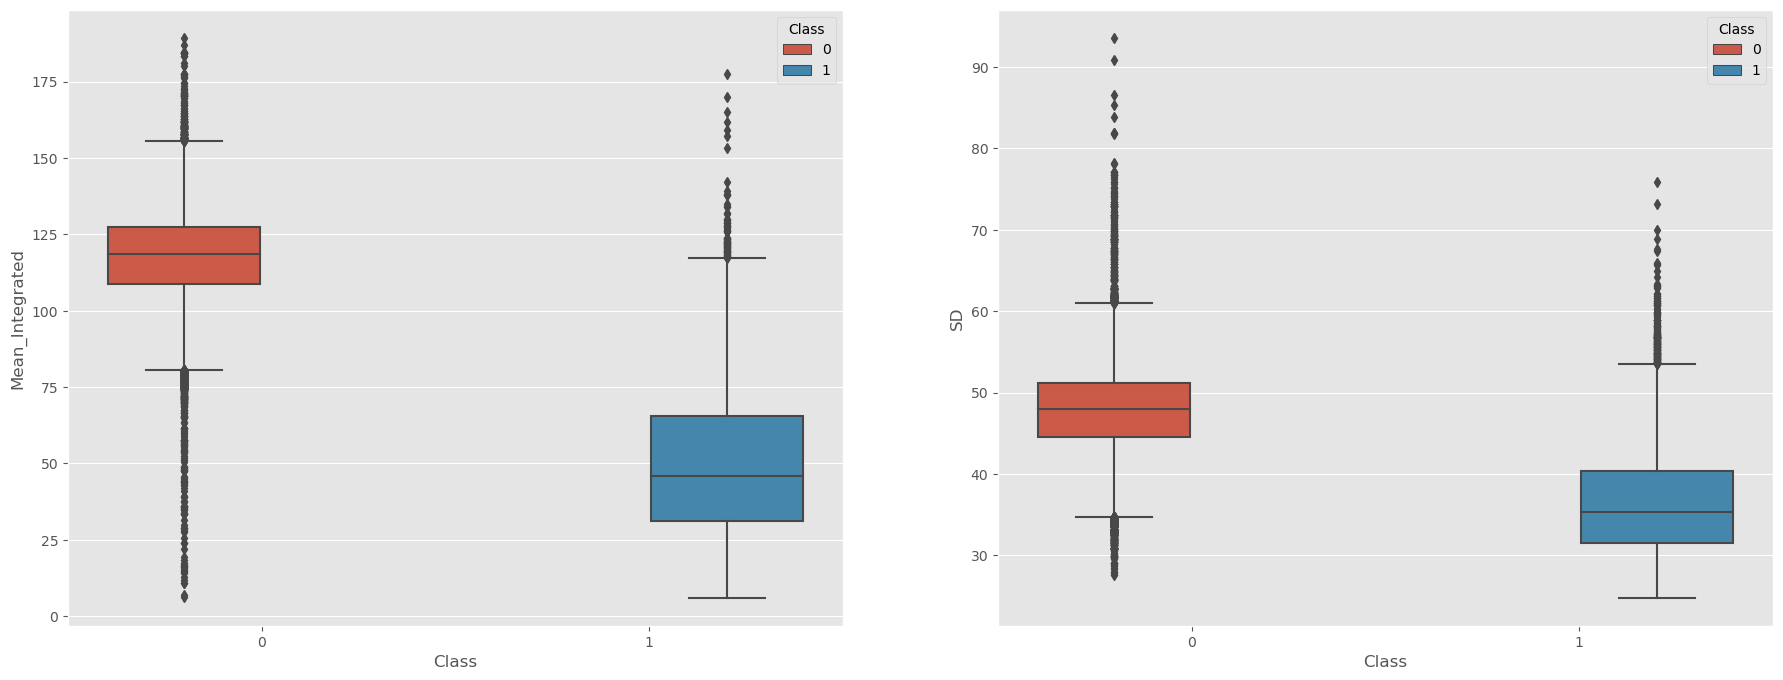

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'Class', y = 'Mean_Integrated', hue = 'Class', data = train)
sns.boxplot(ax = axes[1], x = 'Class', y = 'SD', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above boxplots, we see that, on average the median of Class 0 of Mean_Integrated and SD is larger than Class 1.</div>

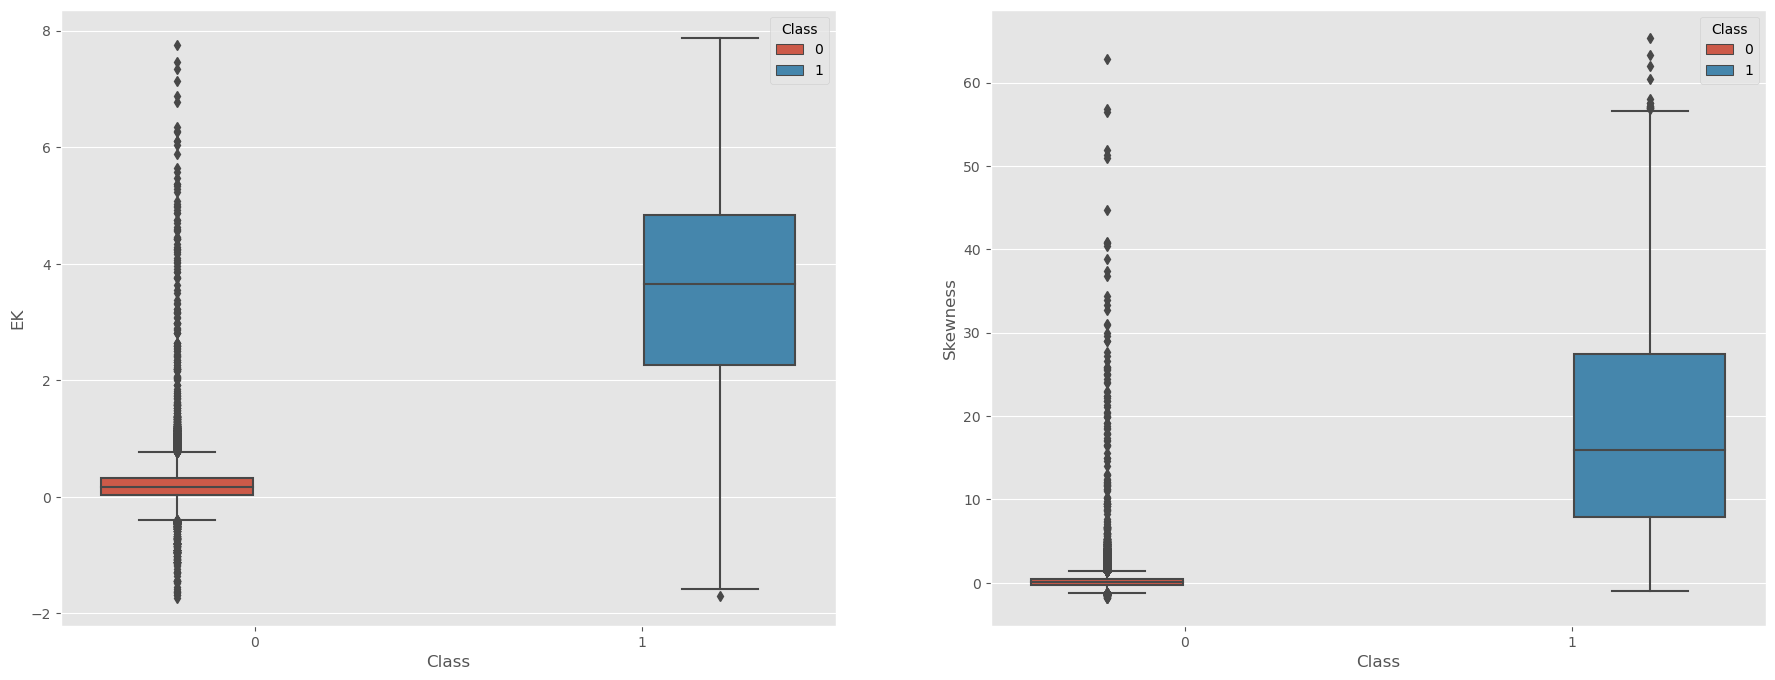

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'Class', y = 'EK', hue = 'Class', data = train)
sns.boxplot(ax = axes[1], x = 'Class', y = 'Skewness', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above boxplots, we see that, on average the median of Class 1 of EK and Skewness is larger than Class 0.</div>

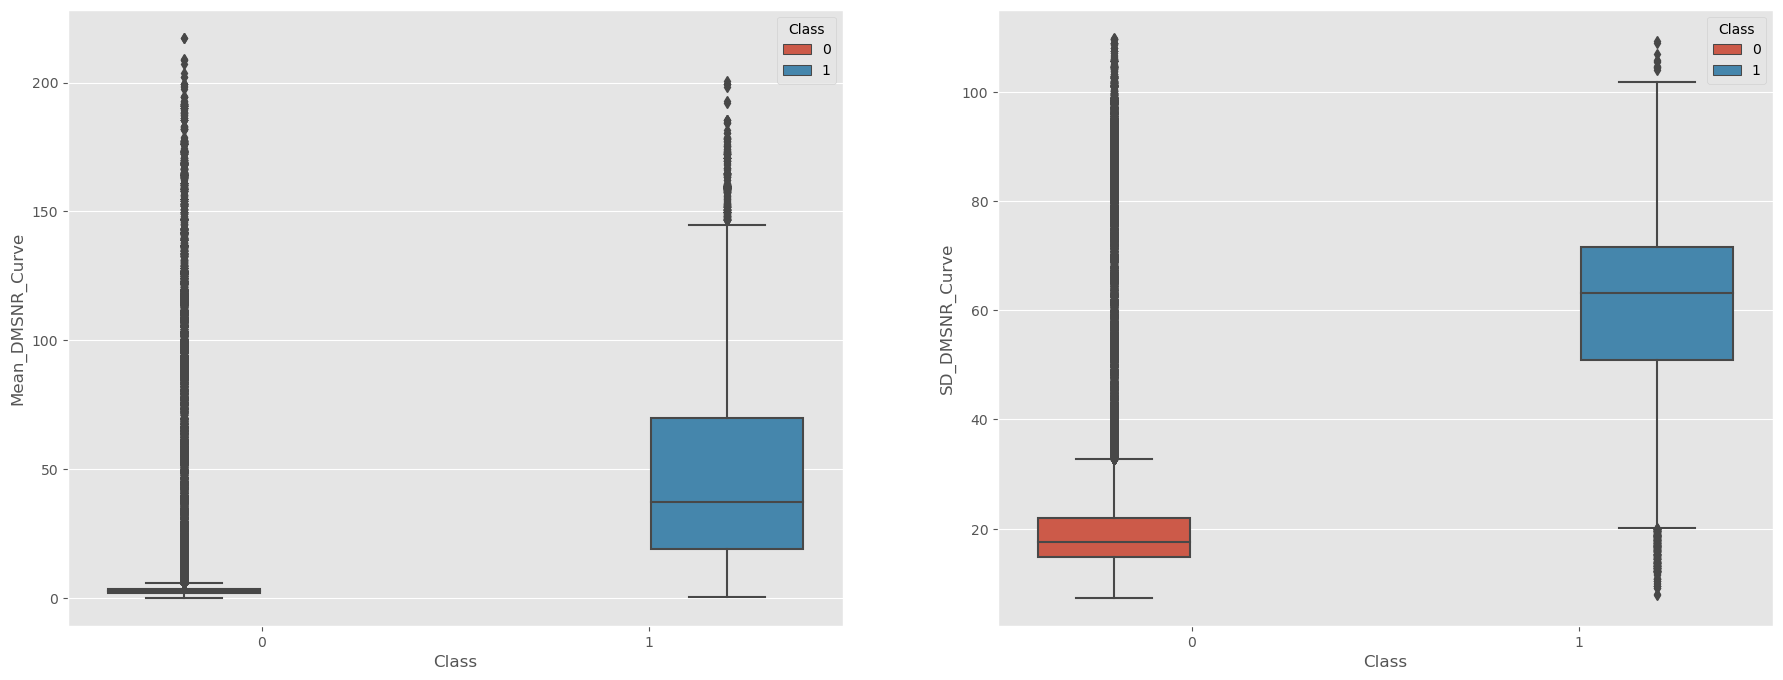

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'Class', y = 'Mean_DMSNR_Curve', hue = 'Class', data = train)
sns.boxplot(ax = axes[1], x = 'Class', y = 'SD_DMSNR_Curve', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above boxplots, we see that, on averae the median of Class 1 of Mean_DMSNR_Curve and SD_DMSNR_Curve is larger than Class 0.</div>

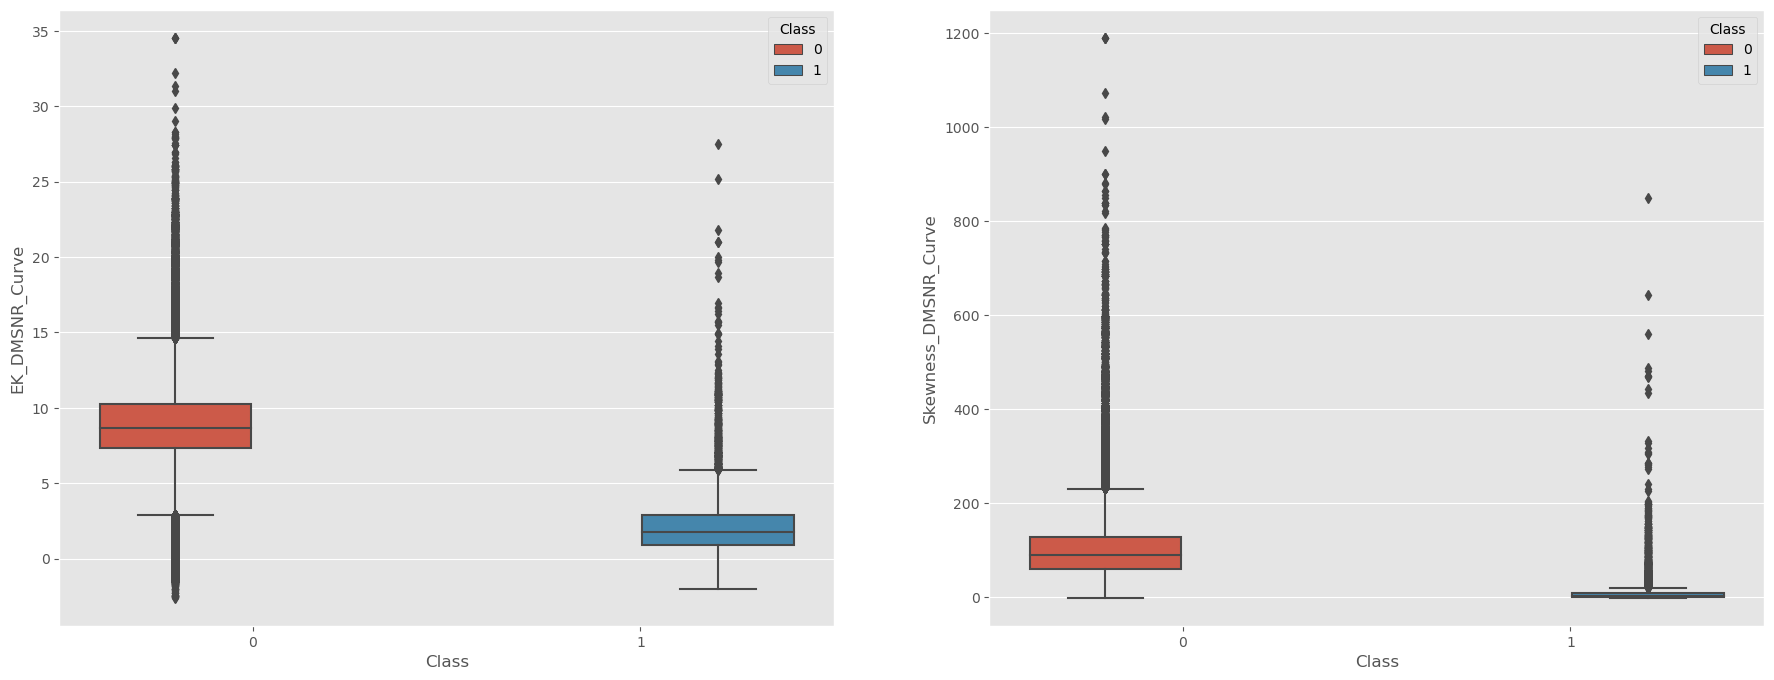

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'Class', y = 'EK_DMSNR_Curve', hue = 'Class', data = train)
sns.boxplot(ax = axes[1], x = 'Class', y = 'Skewness_DMSNR_Curve', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above boxplots, we see that, on average the median of Class 0 of EK_DMSNR_Curve and Skewness_DMSNR_Curve is larger than Class 1.</div>

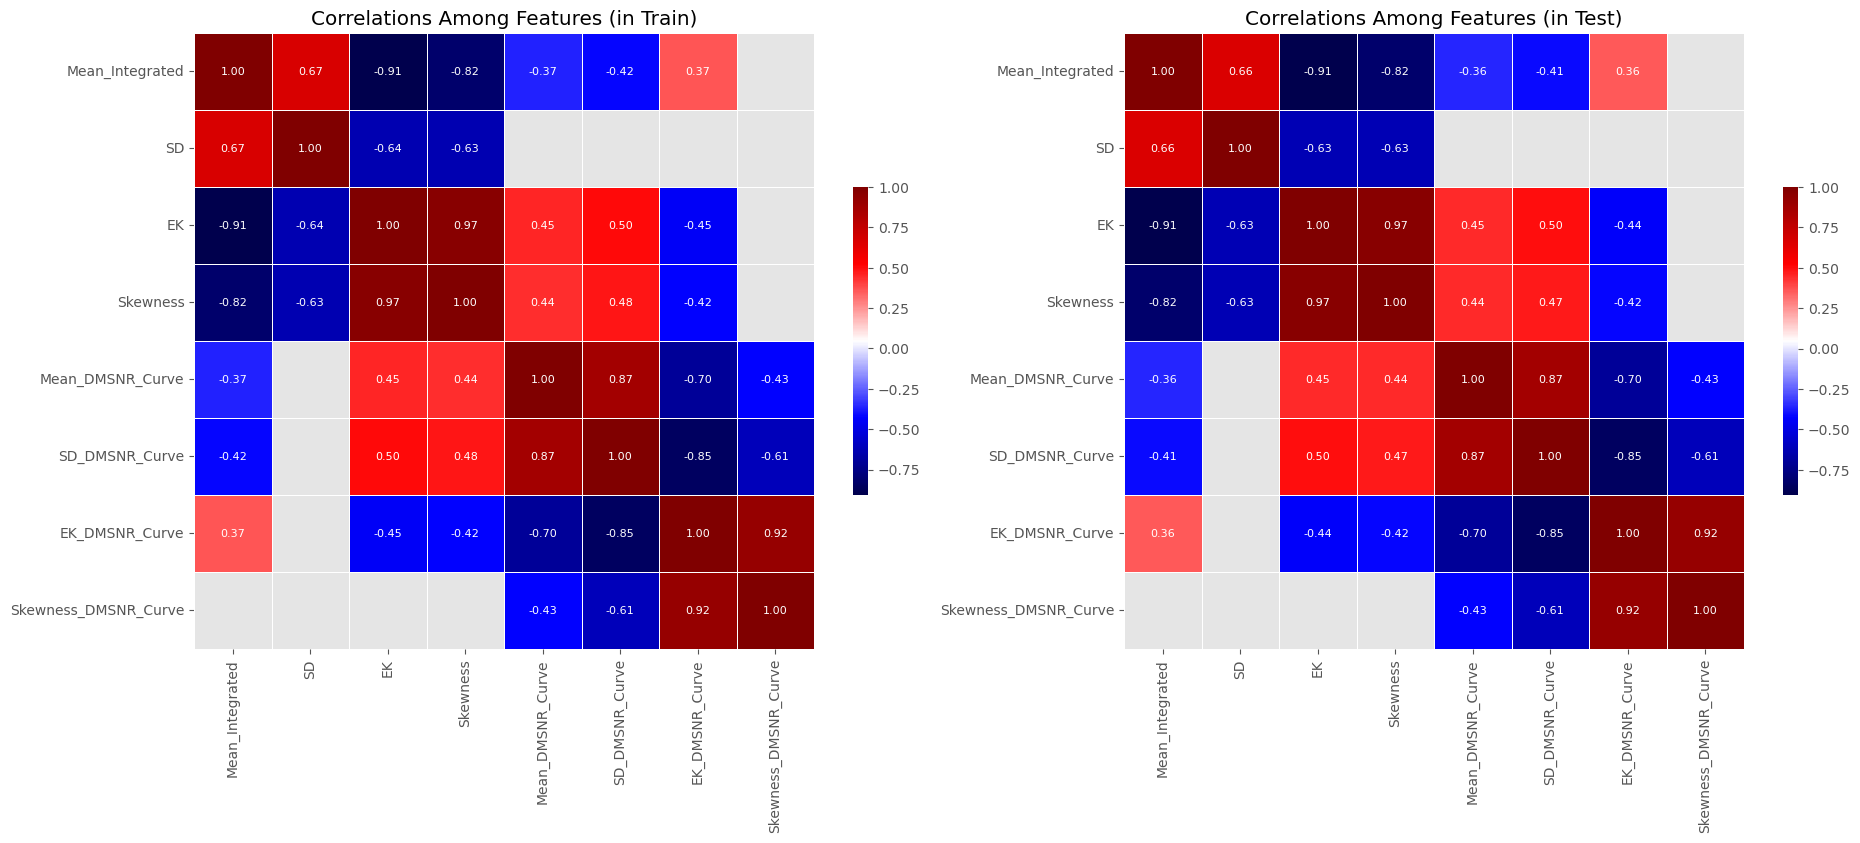

In [14]:
## Explore the correlation between all numerical features
corr_mat_train = train.drop(columns = ['id', 'Class'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['id'], axis = 1).corr()

## Keep only correlation higher than a threshold
threshold = 0.3
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]

fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above heatmaps, we see that the correlation among the features are almost the same in the train and test datasets.
</div>

We next proceed to compare the distribution of the features in the train and test datasets.

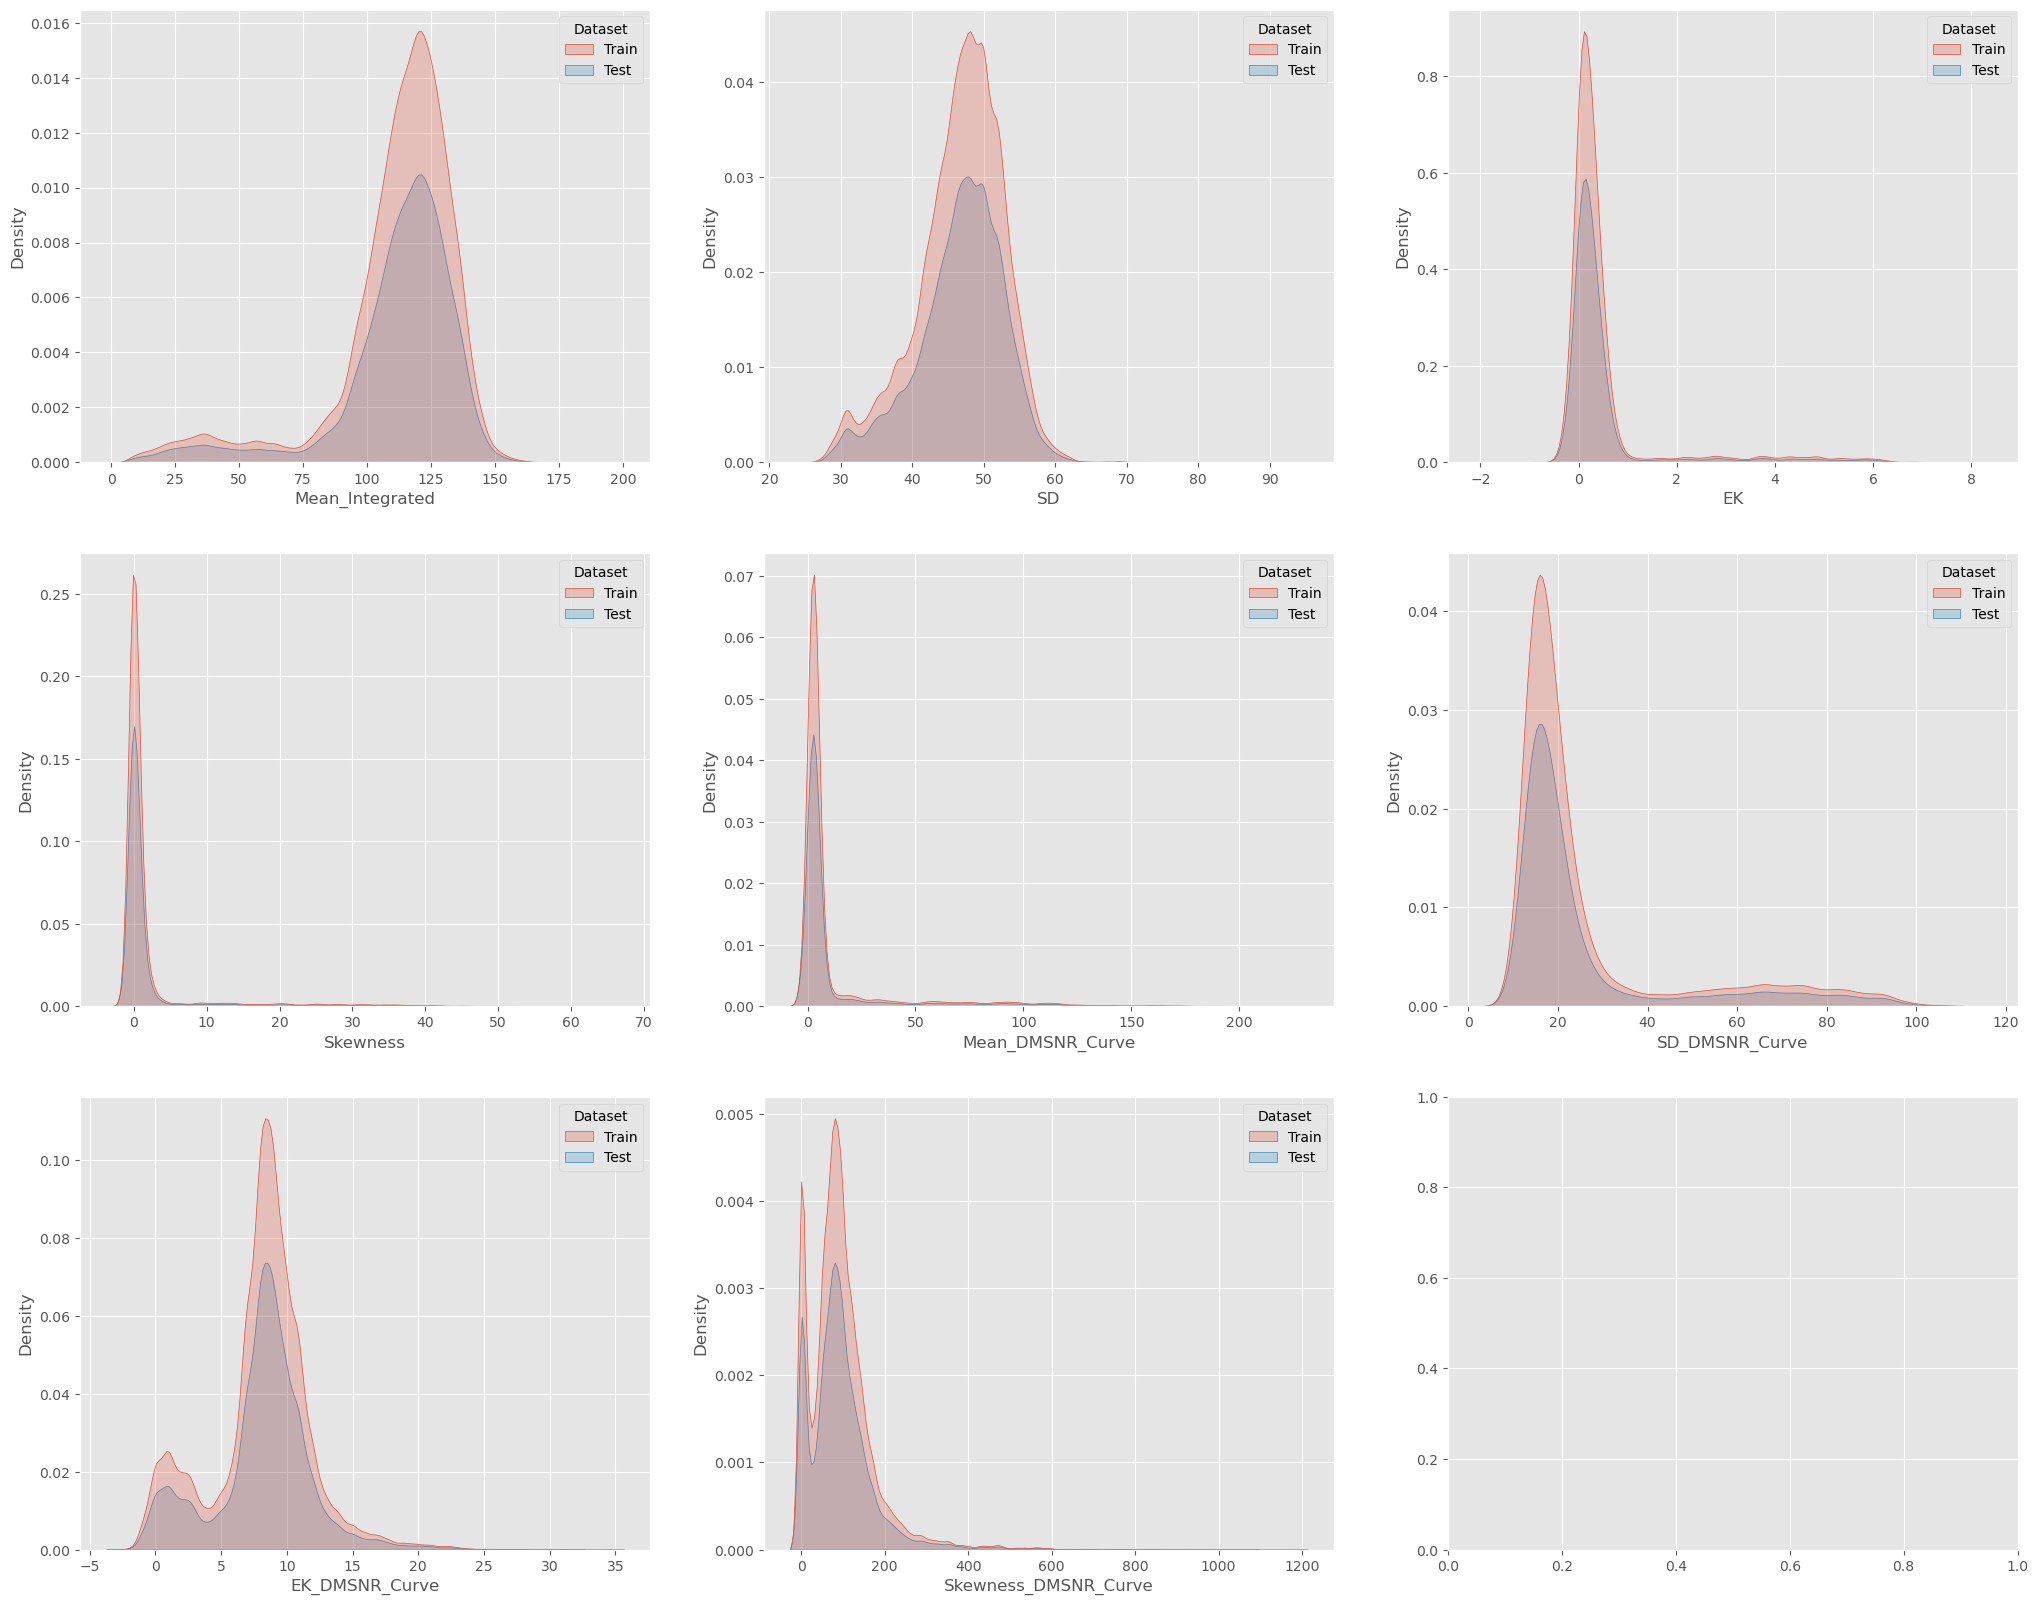

In [15]:
train_vis = train.drop(columns = 'Class', axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(3, 3, figsize = (25, 20))

sns.kdeplot(ax = axes[0, 0], x = 'Mean_Integrated', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'SD', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'EK', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'Skewness', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'Mean_DMSNR_Curve', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'SD_DMSNR_Curve', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 0], x = 'EK_DMSNR_Curve', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 1], x = 'Skewness_DMSNR_Curve', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above density plots, we see that the distributions of the features are very similar in the train and test datasets.
</div>

We next proceed to check for duplicates.

In [16]:
print('There are ', train.shape[0], ' observations in the train datset')
print('There are ', train.drop(columns = ['id', 'Class'], axis = 1).drop_duplicates().shape[0], ' observations in the train datset')

There are  117564  observations in the train datset
There are  117564  observations in the train datset


In [17]:
print('There are ', test.shape[0], ' observations in the test datset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], ' observations in the test datset')

There are  78377  observations in the test datset
There are  78377  observations in the test datset


In [18]:
to_consider = train.drop(columns = ['id', 'Class'], axis = 1).columns.tolist()

train_dup = train.drop(columns = ['id', 'Class'], axis = 1).drop_duplicates()
test_dup = test.drop(columns = ['id'], axis = 1).drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on = to_consider)

print('There are ', duplicates.shape[0], ' rows that appear in the train and test dataset.\n')

There are  0  rows that appear in the train and test dataset.



<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

In this section, we first start by defining the evaluation metric. 

$$\texttt{LogLoss} =  - \frac{1}{n}\sum_{i=1}^n [y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)]$$

where $n$ is the number of rows in the test set, $\hat{y}_i$ is the predicted probability the Class is a pulsar, $y_i$ is 1 if Class is pulsar, otherwise 0, and $\log$ is the natural logarithm. Next, we proceed to build some of the standard tree-based models.

<a id="6.1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Random Forest</h1>

In [19]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, log_loss_scores = list(), list()
preds = list()

## Running 5 times CV
for i in tqdm(range(5)):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        RF_md = RandomForestClassifier(n_estimators = 300, 
                                       max_depth = 3,
                                       min_samples_split = 10,
                                       min_samples_leaf = 10).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        RF_pred_1 = RF_md.predict_proba(X_test)[:, 1]
        RF_pred_2 = RF_md.predict_proba(test_baseline)[:, 1]
        
        ## Computing roc-auc score
        log_loss_scores.append(log_loss(Y_test, RF_pred_1))
        preds.append(RF_pred_2)
        
    cv_scores.append(np.mean(log_loss_scores))

RF_cv_score = np.mean(cv_scores)    
print('The oof average log-loss score of the random forest model over 5-folds (run 5 times) is:', RF_cv_score)

100%|██████████| 5/5 [09:14<00:00, 110.98s/it]

The oof average log-loss score of the random forest model over 5-folds (run 5 times) is: 0.04104142378304455


In [20]:
RF_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['Class'] = RF_preds_test
submission.head()

,id,Class
0,117564,0.003481
1,117565,0.003507
2,117566,0.003490
3,117567,0.019804
4,117568,0.006515


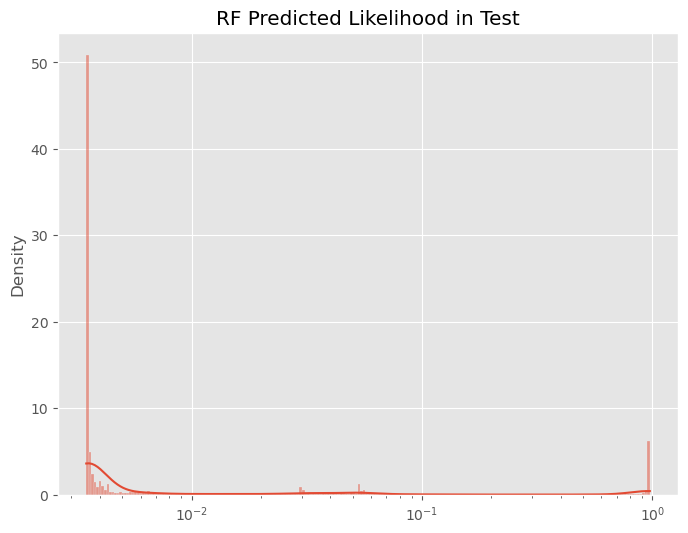

In [21]:
plt.figure(figsize = (8, 6))
sns.histplot(data = RF_preds_test, kde = True, stat = 'density', log_scale = True).set(title = 'RF Predicted Likelihood in Test');

In [22]:
submission.to_csv('RF_Baseline_submission.csv', index = False)

<a id="6.2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">HistGradientBoosting</h1>

In [23]:
cv_scores, log_loss_scores = list(), list()
preds = list()

## Running 5 times CV
for i in tqdm(range(5)):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        RF_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                               early_stopping = False,
                                               learning_rate = 0.01,
                                               max_iter = 300,
                                               max_depth = 3,
                                               max_bins = 255,
                                               min_samples_leaf = 10,
                                               max_leaf_nodes = 10).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        RF_pred_1 = RF_md.predict_proba(X_test)[:, 1]
        RF_pred_2 = RF_md.predict_proba(test_baseline)[:, 1]
        
        ## Computing roc-auc score
        log_loss_scores.append(log_loss(Y_test, RF_pred_1))
        preds.append(RF_pred_2)
        
    cv_scores.append(np.mean(log_loss_scores))

hist_cv_score = np.mean(cv_scores)    
print('The oof average log-loss score of the HistGradientBoosting model over 5-folds (run 5 times) is:', hist_cv_score)

100%|██████████| 5/5 [00:49<00:00,  9.87s/it]

The oof average log-loss score of the HistGradientBoosting model over 5-folds (run 5 times) is: 0.03895359711041617


In [24]:
hist_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['Class'] = hist_preds_test
submission.head()

,id,Class
0,117564,0.005110
1,117565,0.005478
2,117566,0.005110
3,117567,0.047188
4,117568,0.009408


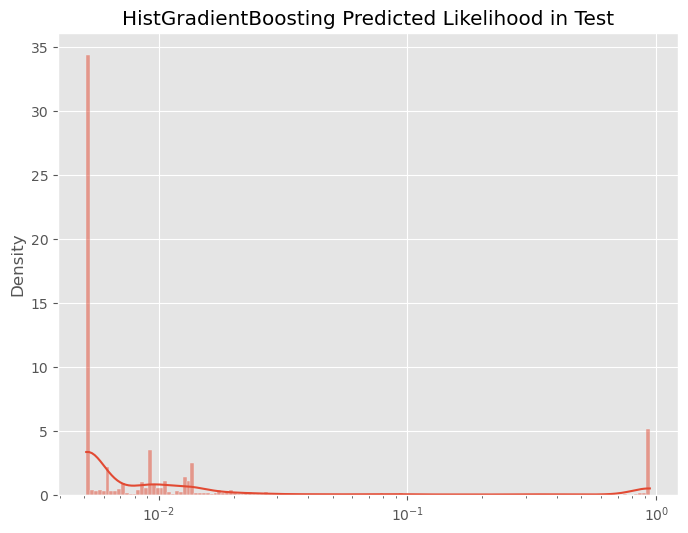

In [25]:
plt.figure(figsize = (8, 6))
sns.histplot(data = hist_preds_test, kde = True, stat = 'density', log_scale = True).set(title = 'HistGradientBoosting Predicted Likelihood in Test');

In [26]:
submission.to_csv('Hist_Baseline_submission.csv', index = False)